In [ ]:
!pip install transformers
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=9f494fb789d9ff60c16eb03ce5d04ff3a2ad889aa3037d723236a9db82c56f52
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
from transformers import pipeline

In [ ]:
triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 10,
    "num_return_sequences": 10,
}
list_triples = []

In [ ]:
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [ ]:
from nltk import sent_tokenize

In [ ]:
import nltk
nltk.download("punkt")
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import wikipedia
def get_text_of_wiki_page(article_name):
    article_name_result = wikipedia.page(wikipedia.search(article_name)[0], auto_suggest=False)
    article_name_content = article_name_result.content
    article_name_content.replace("\n", "").replace("\t", "")
    return article_name_content

In [ ]:
# gsoc = get_text_of_wiki_page("Google summer of code")
# lu = get_text_of_wiki_page("Leipzig University")
# nlp = get_text_of_wiki_page("Natural language processing")
airplane = get_text_of_wiki_page("Airplane")

In [ ]:
airplane

'An airplane (American English), or aeroplane (Commonwealth English), informally plane, is a fixed-wing aircraft that is propelled forward by thrust from a jet engine, propeller, or rocket engine. Airplanes come in a variety of sizes, shapes, and wing configurations. The broad spectrum of uses for airplanes includes recreation, transportation of goods and people, military, and research. Worldwide, commercial aviation transports more than four billion passengers annually on airliners and transports more than 200 billion tonne-kilometers of cargo annually, which is less than 1% of the world\'s cargo movement. Most airplanes are flown by a pilot on board the aircraft, but some are designed to be remotely or computer-controlled such as drones.\nThe Wright brothers invented and flew the first airplane in 1903, recognized as "the first sustained and controlled heavier-than-air powered flight". They built on the works of George Cayley dating from 1799, when he set forth the concept of the mod

In [ ]:
# sent_tokenize = sent_detector.tokenize(gsoc)
# sent_tokenize = sent_detector.tokenize(lu)
# sent_tokenize = sent_detector.tokenize(nlp)
sent_tokenize = sent_detector.tokenize(airplane)

In [ ]:
import ast
import torch

In [ ]:
list_triples = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for text in sent_tokenize:
  model_inputs = tokenizer(text, max_length=256, padding=True, truncation=True, return_tensors = 'pt')
  # Generate
  generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    **gen_kwargs,
  )

  decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

  l1 = []
  for idx, sentence in enumerate(decoded_preds):
      #print(f'Prediction triplets sentence {idx}')
      #print(extract_triplets(sentence))
      l1 += extract_triplets(sentence)

  d1 = {}
  ctr = 0


  for x in l1:
    ctr += 1
    if not str(x) in d1:
        d1[str(x)] = 0
    d1[str(x)] += 1

  for x in d1:
    t = x.replace("}", "")
    final_dict = t + ", 'Confidence': " + str(d1[x]/ctr) + "}"
    #print(final_dict)
    final_dictionary = ast.literal_eval(final_dict)
    list_triples.append(final_dictionary)

In [ ]:
len(list_triples) # For GSOC

921

In [ ]:
len(list_triples) # for leipzig university

1241

In [ ]:
len(list_triples) # for nlp

1778

In [ ]:
len(list_triples) # for airplane

2135

In [ ]:
import pandas as pd
# gsoc_triples = pd.DataFrame(list_triples)
# lp_triples = pd.DataFrame(list_triples)
# nlp_triples = pd.DataFrame(list_triples)
airplane_triples = pd.DataFrame(list_triples)

### GSoC triples

In [ ]:
gsoc_triples

,head,type,tail,Confidence
0,Google Summer of Code,organizer,Google,0.153846
1,Google Summer of Code,conferred by,Google,0.076923
2,Google Summer of Code,founded by,Google,0.076923
3,Google Summer of Code,creator,Google,0.076923
4,Google Summer of Code,named after,Google,0.076923
...,...,...,...,...
916,"Google Summer of Code Full of Stats - Part 3, ...",point in time,"August 5, 2013",0.100000
917,Google Summer of Code Full of Stats,start time,"August 5, 2013",0.100000
918,Google Summer of Code Full of Stats,point in time,"August 5, 2013",0.100000
919,Google Summer of Code Full of Stats - Part 3,end time,"August 5, 2013",0.100000


In [ ]:
gsoc_triples[(gsoc_triples['Confidence']>0.3) & (gsoc_triples['type']!='point in time')]

,head,type,tail,Confidence
238,Chris DiBona,employer,Google,0.357143
245,Mozilla,developer,Gervase Markham,0.333333
248,Gervase Markham,employer,Mozilla,0.333333
525,University of Moratuwa,inception,2008,0.357143
528,Wrocław University of Technology,member of,GSoC,0.500000
593,Moratuwa,country,Sri Lanka,0.357143
600,Polytechnic University of Bucharest,country,Romania,0.333333
639,Dhirubhai Ambani Institute of Information and ...,country,India,0.357143


In [ ]:
gsoc_triples.to_csv("gsoc_triples.csv")

<Axes: >

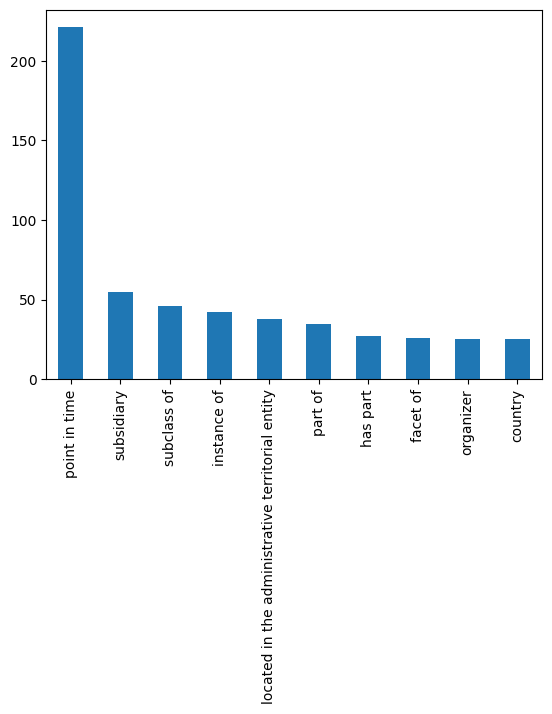

In [ ]:
gsoc_triples['type'].value_counts()[:10].plot(kind='bar')

In [ ]:
relations = gsoc_triples['type'].value_counts()

In [ ]:
relations = pd.DataFrame(relations, columns=['type','count']).reset_index()

In [ ]:
relations

,index,type,count
0,point in time,221,NaN
1,subsidiary,55,NaN
2,subclass of,46,NaN
3,instance of,42,NaN
4,located in the administrative territorial entity,38,NaN
...,...,...,...
70,programming language,1,NaN
71,based on,1,NaN
72,population,1,NaN
73,replaces,1,NaN


In [ ]:
relations[relations['type']<3]

,index,type,count
50,uses,2,NaN
51,affiliation,2,NaN
52,movement,2,NaN
53,follows,2,NaN
54,applies to jurisdiction,2,NaN
55,manufacturer,2,NaN
56,occupation,2,NaN
57,studied by,2,NaN
58,named after,2,NaN
59,studies,2,NaN


### Leipzig university triples

In [ ]:
lp_triples

,head,type,tail,Confidence
0,Leipzig University,located in the administrative territorial entity,Leipzig,0.111111
1,Leipzig University,country,Germany,0.138889
2,Leipzig,located in the administrative territorial entity,Saxony,0.111111
3,Leipzig,country,Germany,0.138889
4,Saxony,contains administrative territorial entity,Leipzig,0.125000
...,...,...,...,...
1236,Robert Appleton,place of birth,New York,0.100000
1237,Robert Appleton Company,located in the administrative territorial entity,New York,0.100000
1238,Robert Appleton Company,place of publication,New York,0.100000
1239,Appleton Company,headquarters location,New York,0.100000


In [ ]:
lp_triples.to_csv("lp_triples.csv")

### NLP

In [ ]:
nlp_triples.to_csv("nlp_triples.csv")

### Airplane

In [ ]:
airplane_triples.to_csv("airplane_triples.csv")

In [ ]:
airplane_triples

,head,type,tail,Confidence
0,rocket engine,subclass of,jet engine,0.090909
1,jet engine,subclass of,rocket engine,0.090909
2,jet engine,uses,thrust,0.090909
3,jet engine,subclass of,aircraft,0.181818
4,jet engine,part of,aircraft,0.090909
...,...,...,...,...
2130,0-8027-7691-4,publisher,Aerospaceweb,0.090909
2131,0-8027-7691-4,part of,Aeroplane centre,0.181818
2132,How Airplanes Work – Howstuffworks.org,publisher,Aeroplane centre,0.090909
2133,0-8027-7691-4,part of,Aerospaceweb,0.090909


### Explore

In [ ]:
sent_tokenize[0], model.device

('Natural language processing (NLP) is an interdisciplinary subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data.',
 device(type='cuda', index=0))

In [ ]:
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50272, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50272, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inputs = tokenizer(sent_tokenize[0], max_length=256, padding=True, truncation=True, return_tensors = 'pt')
# Generate
generated_tokens = model.generate(
  model_inputs["input_ids"].to(device),
  attention_mask=model_inputs["attention_mask"].to(device),
  **gen_kwargs,
)

In [ ]:
decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

In [ ]:
decoded_preds

['<s><triplet> natural language <subj> linguistics <obj> studied by</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> computer science <subj> artificial intelligence <obj> has part <triplet> artificial intelligence <subj> computer science <obj> part of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '<s><triplet> Natural language processing <subj> linguistics <obj> subclass of <triplet> computer science <subj> artificial intelligence <obj> has part <triplet> artificial intelligence <subj> computer science <obj> par